In [1]:
#prep

import hail as hl
import hail.expr.aggregators as agg
from typing import *
hl.init()
import pandas as pd
import time as tm
from scipy import stats
import numpy as np
import random
from matplotlib import pyplot as plt

fn_default = "gs://gnomad-qingbowang/vivli_datathon/Shared/As individual files/Trial 1-GIST/syn_a_drgexp_plus_event.csv"

def plot_histogram(data_path_in_cloud=fn_default, filter_by=("AVGDOS_N",10), group_by="NONE", hist_of="TERMREAS", cnt_threshold=10):
    #larger than is always true for the filtering
    print ("accessing the data on cloud. {0}".format(tm.ctime()))
    with hl.hadoop_open(data_path_in_cloud, 'r') as f:
        d = pd.read_csv(f, sep=",")
    print ("filtering the data by {0} larger than {1}. {2}".format(filter_by[0], filter_by[1], tm.ctime()))
    d = d[d[filter_by[0]]>filter_by[1]]
    if group_by=="NONE":#just simple plot of a column
        print ("plotting {0}".format(hist_of))
        d[hist_of].hist()
        plt.xlabel(hist_of)
        plt.ylabel("number of samples")
        plt.title("histogram for {0} (real data)".format(hist_of))
    #plt.show()
    """
    else: #WIP
        print ("generating the histogram of {0} grouped by {1}. {2}".format(hist_of, group_by, tm.ctime())
        for i in d[group_by].unique():
               if sum(d[group_by]==i)>cnt_threshold:
                   plt.hist(, label = i)
        plt.legend(title=group_by)
    """

def get_basic_stats(data_path_in_cloud=fn_default, filter_by=("AVGDOS_N",10), group_by=["AVGDOS_C"], agg_with="TERMREAS", stats_to_return="ALL", cnt_threshold=10):
    #larger than is always true for the filtering
    print ("accessing the data on cloud. {0}".format(tm.ctime()))
    with hl.hadoop_open(data_path_in_cloud, 'r') as f:
        d = pd.read_csv(f, sep=",")
    print ("filtering the data by {0} larger than {1}. {2}".format(filter_by[0], filter_by[1], tm.ctime()))
    d = d[d[filter_by[0]]>filter_by[1]]
    print ("grouping the data by {0}. {1}".format(",".join(group_by), tm.ctime()))
    agg = d.groupby(group_by).agg(agg_with).describe()
    size_bef = agg["count"].sum() #keep the size before filtering
    #fiiter to stats to return
    agg = agg[agg["count"]>=cnt_threshold]
    size_af = agg["count"].sum()
    print ("{0} samples are filtered out because of having less than {1} samples after aggregation".format(size_bef - size_af, cnt_threshold))
    if stats_to_return!="ALL":
        agg = agg.loc[:,stats_to_return]
    return (agg)
    

#function to output the samples that satisfies the condition (not shared to individuals)
def get_sample_ids(data_path_in_cloud=fn_default, filter_by=("AVGDOS_N",10), group_by="AVGDOS_C", cnt_threshold=0, id_column="MASK_ID"):
    #group_by is for single column for now. multiple columns implementation later.
    print ("accessing the data on cloud. {0}".format(tm.ctime()))
    with hl.hadoop_open(data_path_in_cloud, 'r') as f:
        d = pd.read_csv(f, sep=",")
    print ("filtering the data by {0} larger than {1}. {2}".format(filter_by[0], filter_by[1], tm.ctime()))
    d = d[d[filter_by[0]]>filter_by[1]]
    output_dict = {}
    uni_groups = d[group_by].unique()
    for i in uni_groups:
        output_dict[i] = list(d[d[group_by]==i][id_column])
    print ("returing a dictionary of key={0}, value={1}".format(group_by, id_column))
    return (output_dict)


#function to perform statistical test
#for a single column: do it with 1 vs others, multiple times, summarize the result
def perform_statistical_test(data_path_in_cloud=fn_default, 
                             filter_by=("AVGDOS_N",10), group_by="AVGDOS_C", test_column="TERMREAS", test_method="t_test", cnt_threshold=10):
    #t-test for quantitative, chi^2 test for qualitative
    print ("accessing the data on cloud. {0}".format(tm.ctime()))
    with hl.hadoop_open(data_path_in_cloud, 'r') as f:
        d = pd.read_csv(f, sep=",")
    print ("filtering the data by {0} larger than {1}. {2}".format(filter_by[0], filter_by[1], tm.ctime()))
    d = d[d[filter_by[0]]>filter_by[1]]
    uni_groups = d[group_by].unique()
    output = {}
    output["{0} category".format(group_by)] = "{0} difference".format(test_column)
    for i in uni_groups:
        case = np.array(d[d[group_by]==i][test_column])
        oth = np.array(d[d[group_by]!=i][test_column])
        #remove nas
        case = case[~np.isnan(case)]
        oth = oth[~np.isnan(oth)]
        if test_method=="t_test":
            tst = stats.ttest_ind(case, oth)
            keyname = "{0} vs others".format(i)
            output[keyname] = tst
        #elif test_method=="chi_square":
        #    tst = stats.chisquare(case, oth)
        #    keyname = "{0} vs others".format(i)
        #    output[keyname] = tst
        #implement chi^2 test later...
        else:
            return ("error: only t_test (for quantitative) or chi_square (for qualitative) can be used")
    print ("returing the result of {0} \n for the difference of {1} \n in each of the category in {2}".format(test_method, test_column, group_by))
    return (output)

def perform_permutation(patient_ids=np.arange(1, 773+1), id_column="MASK_ID", N_PERM=10, data_path_in_cloud=fn_default):  
    print ("accessing the data on cloud. {0}".format(tm.ctime()))
    with hl.hadoop_open(data_path_in_cloud, 'r') as f:
        drgexp = pd.read_csv(f, sep=",", index_col=0)
    columns = list(drgexp) 
    col_dtypes = ['int64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64', 
                  'int64', 'int64', 'int64', 'int64', 'int64', 'int64', 'int64', "int64"]    
    all_cols = []
    for i in range(N_PERM):
        random_patient_id = random.sample(set(patient_ids), 3)
        permuted_drgexp = drgexp[drgexp[id_column].isin(random_patient_id)]
        new_col = []
        for col_id,col in enumerate(columns):
            if col_dtypes[col_id] in ['float64']:
                new_col.append( np.mean(permuted_drgexp[col]))
            elif col_dtypes[col_id] in ['int64']:
                new_col.append(stats.mode(permuted_drgexp[col])[0][0])
            else:
                new_col.append(stats.mode(permuted_drgexp[col])[0][0])
        all_cols.append(new_col)
    new_df = pd.DataFrame(all_cols, columns = list(columns))
    del new_df["MASK_ID"]
    new_df["MASK_ID_synthetic"] = np.arange(new_df.shape[0])
    return(new_df)

Running on Apache Spark version 2.4.3
SparkUI available at http://qbwcluster-m.c.broad-mpg-gnomad.internal:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.14-c489420c236d
LOGGING: writing to /home/hail/hail-20190621-1933-0.2.14-c489420c236d.log


accessing the data on cloud. Fri Jun 21 19:33:49 2019
filtering the data by AVGDOS_N larger than 10. Fri Jun 21 19:33:50 2019
plotting AVGDOS_N


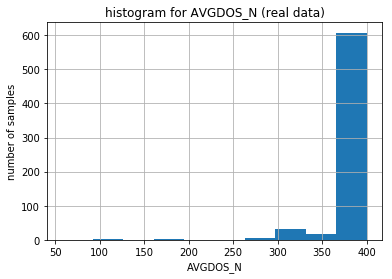

In [2]:
#show distribution:
plot_histogram(hist_of="AVGDOS_N")

In [3]:
#get basic stats
test = get_basic_stats(filter_by=("AVGDOS_C",2), group_by=["EVENT"], agg_with="AVGDOS_N", stats_to_return="ALL", cnt_threshold=10)
print ("\n agg stats for AVGDOS_C:")
test

accessing the data on cloud. Fri Jun 21 19:33:54 2019
filtering the data by AVGDOS_C larger than 2. Fri Jun 21 19:33:54 2019
grouping the data by EVENT. Fri Jun 21 19:33:54 2019
0.0 samples are filtered out because of having less than 10 samples after aggregation

 agg stats for AVGDOS_C:


,count,mean,std,min,25%,50%,75%,max
EVENT,,,,,,,,
0,553.0,394.141971,19.350352,300.00,400.0,400.0,400.0,400.0
1,96.0,394.595417,19.372020,303.95,400.0,400.0,400.0,400.0


In [4]:
#perform statistical test
test2 = perform_statistical_test(filter_by=("AVGDOS_C",2), group_by="EVENT", test_column="AVGDOS_N", cnt_threshold=10)
test2

accessing the data on cloud. Fri Jun 21 19:33:59 2019
filtering the data by AVGDOS_C larger than 2. Fri Jun 21 19:33:59 2019
returing the result of t_test 
 for the difference of AVGDOS_N 
 in each of the category in EVENT


{'EVENT category': 'AVGDOS_N difference',
 '1 vs others': Ttest_indResult(statistic=0.2119047673095539, pvalue=0.8322480665181062),
 '0 vs others': Ttest_indResult(statistic=-0.2119047673095539, pvalue=0.8322480665181062)}

In [5]:
#synthetic data:
syn_data = perform_permutation(N_PERM=773)

accessing the data on cloud. Fri Jun 21 19:34:05 2019


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


accessing the data on cloud. Fri Jun 21 19:34:11 2019
filtering the data by AVGDOS_N larger than 10. Fri Jun 21 19:34:11 2019
plotting AVGDOS_N
---


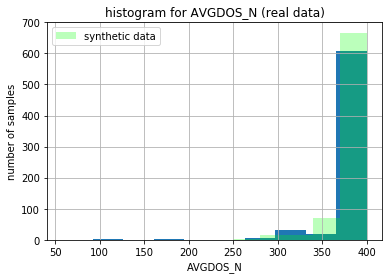

In [6]:
#synthetic data histogram looks OK
plot_histogram(hist_of="AVGDOS_N")
print ("---")
syn_data[syn_data.AVGDOS_N>10].AVGDOS_N.hist(label="synthetic data", color="#00ff0044")
plt.legend()

In [7]:
#compare basic stats:
test = get_basic_stats(filter_by=("AVGDOS_C",2), group_by=["EVENT"], agg_with="AVGDOS_N", stats_to_return="ALL", cnt_threshold=10)
print ("\n agg stats for AVGDOS_C, real data:")

display(test)

print ("---")
print ("\n agg stats for AVGDOS_C, synthetic data:")
syn_agg = syn_data[syn_data.AVGDOS_C>2].groupby("EVENT").agg("AVGDOS_N").describe()
display(syn_agg)

accessing the data on cloud. Fri Jun 21 19:34:15 2019
filtering the data by AVGDOS_C larger than 2. Fri Jun 21 19:34:16 2019
grouping the data by EVENT. Fri Jun 21 19:34:16 2019
0.0 samples are filtered out because of having less than 10 samples after aggregation

 agg stats for AVGDOS_C, real data:


,count,mean,std,min,25%,50%,75%,max
EVENT,,,,,,,,
0,553.0,394.141971,19.350352,300.00,400.0,400.0,400.0,400.0
1,96.0,394.595417,19.372020,303.95,400.0,400.0,400.0,400.0


---

 agg stats for AVGDOS_C, synthetic data:


,count,mean,std,min,25%,50%,75%,max
EVENT,,,,,,,,
0,718.0,391.778821,17.994212,286.056667,394.873333,400.0,400.0,400.0
1,35.0,394.290571,13.270322,351.975000,397.341667,400.0,400.0,400.0


In [8]:
#compare test stats:

#t-test for real data

#t-test for synthetic data
group_by = "EVENT"
test_column = "AVGDOS_N"
uni_groups = syn_data["EVENT"].unique()
output = {}
output["{0} category".format(group_by)] = "{0} difference".format(test_column)
for i in uni_groups:
        case = np.array(syn_data[syn_data[group_by]==i][test_column])
        oth = np.array(syn_data[syn_data[group_by]!=i][test_column])
        #remove nas
        case = case[~np.isnan(case)]
        oth = oth[~np.isnan(oth)]
        tst = stats.ttest_ind(case, oth)
        keyname = "{0} vs others".format(i)
        output[keyname] = tst
test_syndata = output
#comparison with real data:
print ("t-test, real data:")
test2

t-test, real data:


{'EVENT category': 'AVGDOS_N difference',
 '1 vs others': Ttest_indResult(statistic=0.2119047673095539, pvalue=0.8322480665181062),
 '0 vs others': Ttest_indResult(statistic=-0.2119047673095539, pvalue=0.8322480665181062)}

In [9]:
print ("t-test, synthetic data:")
test_syndata

t-test, synthetic data:


{'EVENT category': 'AVGDOS_N difference',
 '0 vs others': Ttest_indResult(statistic=0.5188383228301839, pvalue=0.6040225664014929),
 '1 vs others': Ttest_indResult(statistic=-0.5188383228301839, pvalue=0.6040225664014929)}